In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

# 1) Visual Evaluation

In [67]:
# Load the data
data_2015 = pd.read_csv("46047h2015.txt",sep='\s+').drop(axis='index',labels=0)
data_2016 = pd.read_csv("46047h2016.txt",sep='\s+').drop(axis='index',labels=0)

# Define a function to tidy up the data by removing the top row and renaming some columns
def tidy_up_data(data):
    data = data.rename(columns={"#YY":"year","MM":"month","DD":"day","hh":"hour","mm":"minute"})
    data_datetime = pd.to_datetime(data[["year","month","day","hour","minute"]])
    data['Datetime'] = data_datetime
    data = data.set_index('Datetime')
    for variable in (['WSPD','WVHT','WTMP','ATMP']):
        data[variable] = data[variable].astype('float') # Change from object type to float type
    return data

data_2015 = tidy_up_data(data_2015)
data_2016 = tidy_up_data(data_2016)

# Define datetime values for each point
datetime_2015 = pd.to_datetime(data_2015[["year","month","day","hour","minute"]]) # Converting to datetime format
datetime_2016 = pd.to_datetime(data_2016[["year","month","day","hour","minute"]])

# Join the data together
data = pd.concat([data_2015, data_2016]) # Combining 2015 and 2016 data together
datetime = datetime_2015.append(datetime_2016)

In [68]:
data

,year,month,day,hour,minute,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
Datetime,,,,,,,,,,,,,,,,,,
2014-12-31 23:50:00,2014,12,31,23,50,5,7.3,9.2,3.13,10.00,7.19,320,1017.3,12.7,16.8,999.0,99.0,99.00
2015-01-01 00:50:00,2015,01,01,00,50,352,7.2,8.9,2.95,10.00,6.89,318,1017.4,12.8,16.9,999.0,99.0,99.00
2015-01-01 01:50:00,2015,01,01,01,50,350,5.8,7.9,2.84,10.00,6.94,321,1018.0,12.7,16.9,999.0,99.0,99.00
2015-01-01 02:50:00,2015,01,01,02,50,359,4.4,6.0,2.75,10.00,7.10,315,1018.3,12.6,16.9,999.0,99.0,99.00
2015-01-01 03:50:00,2015,01,01,03,50,2,5.2,6.8,2.65,10.00,7.19,320,1018.6,12.8,16.9,999.0,99.0,99.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,2016,12,31,18,50,284,5.5,6.8,1.99,13.79,7.38,312,1015.9,14.4,16.5,999.0,99.0,99.00
2016-12-31 19:50:00,2016,12,31,19,50,303,6.7,8.0,1.82,13.79,7.32,321,1015.1,14.2,16.5,999.0,99.0,99.00
2016-12-31 20:50:00,2016,12,31,20,50,273,4.8,6.8,1.85,14.81,7.13,316,1014.1,13.7,16.5,999.0,99.0,99.00


In [69]:
# Define the variables of interest
wind = data['WSPD']
wave_height = data['WVHT']
water_temp = data['WTMP']
air_temp = data['ATMP']

Missing data are identified by either 99 or 999 in the record. I set these to NaN.

In [71]:
# Make sure missing values have nan value
wind[wind == 99] = np.nan
wave_height[wave_height == 99] = np.nan
water_temp[water_temp == 999] = np.nan
air_temp[air_temp == 999] = np.nan


C:\Users\euand\AppData\Local\Temp/ipykernel_26292/830287829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind[wind == 99] = np.nan
C:\Users\euand\AppData\Local\Temp/ipykernel_26292/830287829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_height[wave_height == 99] = np.nan
C:\Users\euand\AppData\Local\Temp/ipykernel_26292/830287829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_temp[water_temp == 999] = np.na

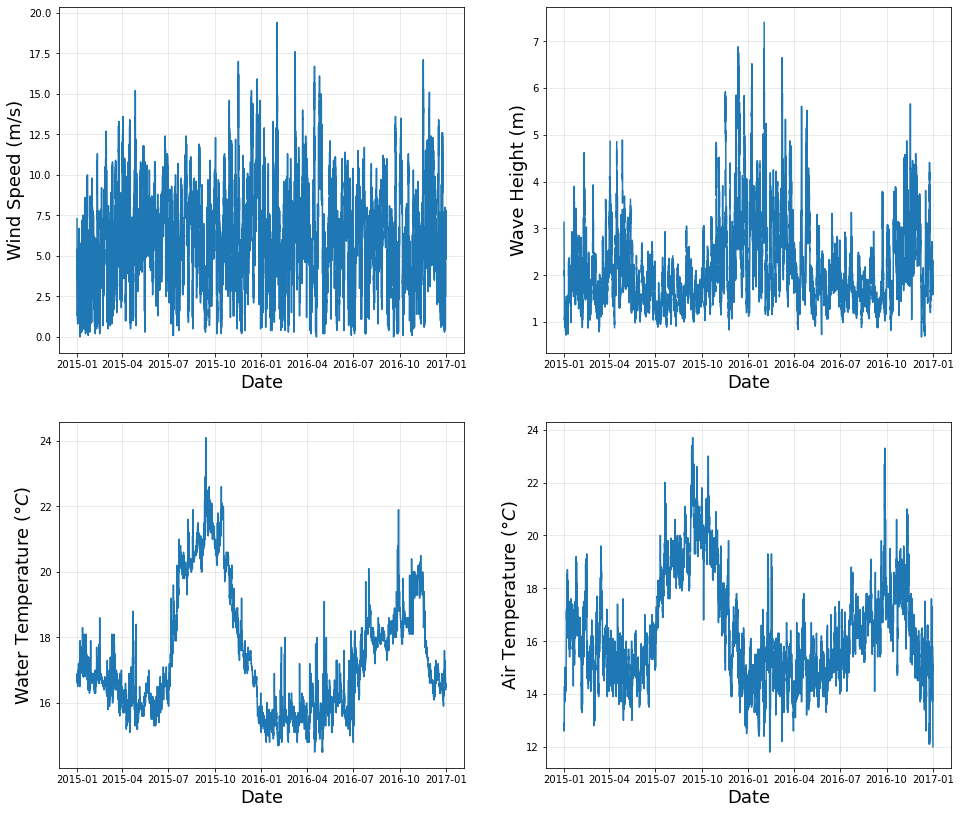

<function matplotlib.pyplot.close(fig=None)>

In [125]:
# Define a function with plots a timeseries on a given axis
def plot_timeseries(ax, var, y_label):
    ax.plot(datetime, var)
    ax.set_xlabel('Date', fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.grid(alpha=0.3)

# Create a figure with the two-year timeseries for each variable
fig = plt.figure(figsize=(16,14))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
(ax1, ax2), (ax3, ax4) = gs.subplots()

plot_timeseries(ax1, wind, y_label='Wind Speed (m/s)')
plot_timeseries(ax2, wave_height, y_label='Wave Height (m)')
plot_timeseries(ax3, water_temp, y_label='Water Temperature ($\degree C$)')
plot_timeseries(ax4, air_temp, y_label='Air Temperature ($\degree C$)')
plt.show()
plt.close

# 2) Monthly means

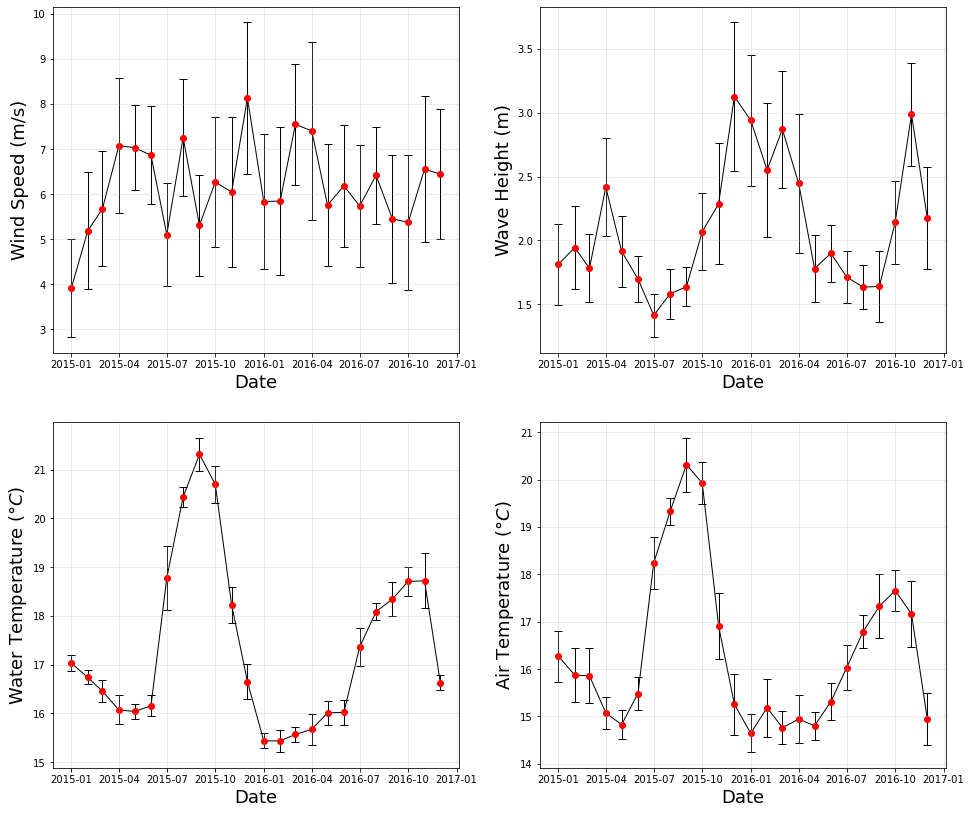

<function matplotlib.pyplot.close(fig=None)>

In [85]:
# Define a function which calculates the monthly mean and associated error assuming one independent value per 7 days 
# (roughly 4 independent values per month)
def monthly_mean(var):
    mn_avg_var = var.resample('MS').mean()[1:] # Removing data point from 2014
    mn_err_var = var.resample('MS').std()[1:]/np.sqrt(4) # Removing data point from 2014
    
    return mn_avg_var, mn_err_var

# Define a function which plots the monthly averaged values and errorbars as a timeseries
def plot_timeseries_avg(ax, mn_avg_var, mn_err_var, y_label):
    ax.scatter(mn_avg_var.index.values, mn_avg_var.values, c='r')
    ax.errorbar(mn_avg_var.index.values, mn_avg_var.values, c='k', lw=1, yerr = mn_err_var, capsize=4, zorder=0)
    ax.set_xlabel('Date', fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.grid(alpha=0.3)

# Plot the monthly averaged values and errors for each of the variables
fig = plt.figure(figsize=(16,14))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
(ax1, ax2), (ax3, ax4) = gs.subplots()

plot_timeseries_avg(ax1, monthly_mean(wind)[0], monthly_mean(wind)[1], y_label='Wind Speed (m/s)')
plot_timeseries_avg(ax2, monthly_mean(wave_height)[0], monthly_mean(wave_height)[1], y_label='Wave Height (m)')
plot_timeseries_avg(ax3, monthly_mean(water_temp)[0], monthly_mean(water_temp)[1], y_label='Water Temperature ($\degree C$)')
plot_timeseries_avg(ax4, monthly_mean(air_temp)[0], monthly_mean(air_temp)[1], y_label='Air Temperature ($\degree C$)')
plt.show()
plt.close
    

# 3) Least-squares fit

C:\Users\euand\AppData\Local\Temp/ipykernel_26292/2461493780.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_2015[wind_2015 == 99] = np.nan
C:\Users\euand\AppData\Local\Temp/ipykernel_26292/2461493780.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_height_2015[wave_height_2015 == 99] = np.nan
C:\Users\euand\AppData\Local\Temp/ipykernel_26292/2461493780.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_temp_

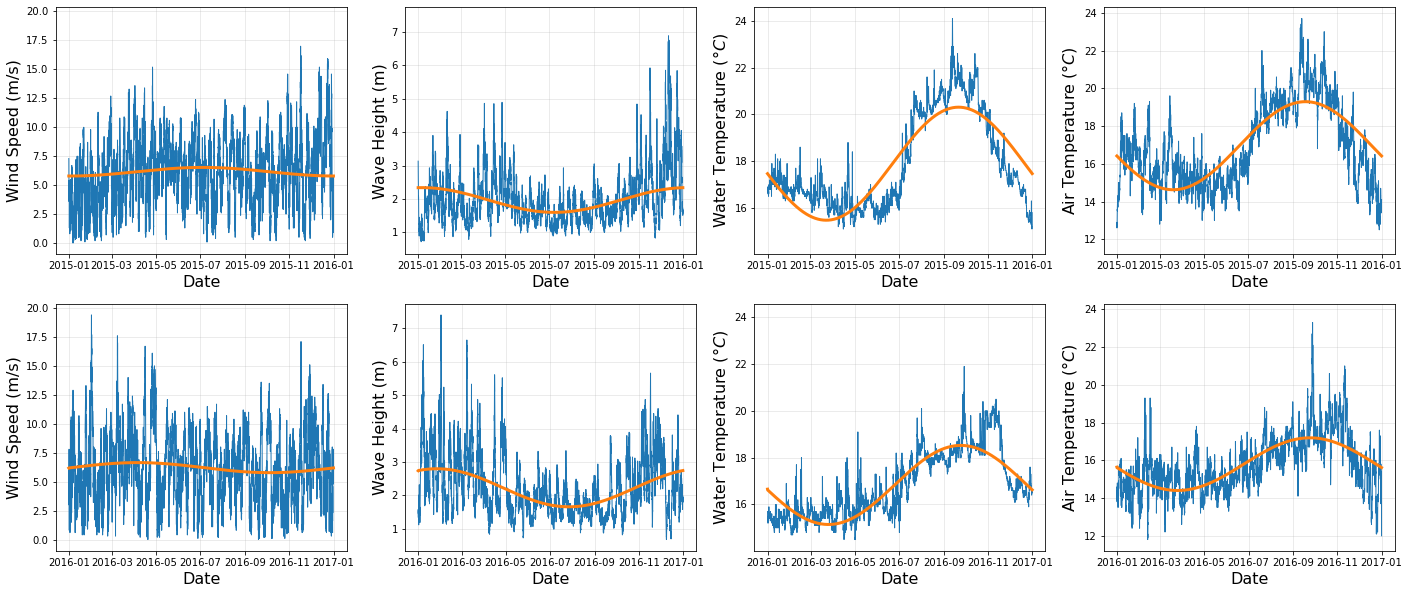

<function matplotlib.pyplot.close(fig=None)>

In [154]:
# Separate the data into separate years
wind_2015 = data_2015['WSPD']
wave_height_2015 = data_2015['WVHT']
water_temp_2015 = data_2015['WTMP']
air_temp_2015 = data_2015['ATMP']
wind_2016 = data_2016['WSPD']
wave_height_2016 = data_2016['WVHT']
water_temp_2016 = data_2016['WTMP']
air_temp_2016 = data_2016['ATMP']

wind_2015[wind_2015 == 99] = np.nan
wave_height_2015[wave_height_2015 == 99] = np.nan
water_temp_2015[water_temp_2015 == 999] = np.nan
air_temp_2015[air_temp_2015 == 999] = np.nan
wind_2016[wind_2016 == 99] = np.nan
wave_height_2016[wave_height_2016 == 99] = np.nan
water_temp_2016[water_temp_2016 == 999] = np.nan
air_temp_2016[air_temp_2016 == 999] = np.nan

# Define a function which calculates the least_squares fit using sines and cosines of a given period.
# Two periods are allowed but the default is just one
# The period is measured in days
def least_squares_fit(var, datetime, P1, P2=False):
    
    # Remove the data with NaN values
    day = datetime.dt.dayofyear+datetime.dt.hour/24
    day_valid = day.drop(var[np.isnan(var)].index)
    var_valid = var.drop(var[np.isnan(var)].index)
        
    if P2:
        A = np.array([np.ones(len(var_valid)), np.sin(2*np.pi*day_valid/P1), np.cos(2*np.pi*day_valid/P1),
             np.sin(2*np.pi*day_valid/P2), np.cos(2*np.pi*day_valid/P2)]).T
    else:
        A = np.array([np.ones(len(var_valid)), np.sin(2*np.pi*day_valid/P1), np.cos(2*np.pi*day_valid/P1)]).T
        
    x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(var_valid)
    
    return A,x

# Define a function which plots the linear fit over the top of the original data
def plot_lin_fit(ax, var, datetime, y_label, P1, P2=False):
    
    # Call the least_square_fit function
    A, x = least_squares_fit(var, datetime, P1=P1, P2=P2)
    
    day = datetime.dt.dayofyear+datetime.dt.hour/24
    day_valid = day.drop(var[np.isnan(var)].index)
    var_valid = var.drop(var[np.isnan(var)].index)
    
    ax.plot(var_valid.index.values, var_valid.values, lw=1)
    ax.plot(var_valid.index.values, A.dot(x), lw=3)
    ax.set_xlabel('Date', fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.grid(alpha=0.3)
    
    return A, x, var_valid

# Plot all the variables again, this time separating the years and adding in the model fit with an annual cycle
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(2, 4, hspace=0.2, wspace=0.2)
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = gs.subplots(sharey='col')
A1a, x1a, wind_2015_valida = plot_lin_fit(ax1, wind_2015, datetime_2015, y_label='Wind Speed (m/s)', P1=365)
A2a, x2a, wave_height_2015_valida = plot_lin_fit(ax2, wave_height_2015, datetime_2015, y_label='Wave Height (m)', P1=365)
A3a, x3a, water_temp_2015_valida = plot_lin_fit(ax3, water_temp_2015, datetime_2015, y_label='Water Temperature ($\degree C$)', P1=365)
A4a, x4a, air_temp_2015_valida = plot_lin_fit(ax4, air_temp_2015, datetime_2015, y_label='Air Temperature ($\degree C$)', P1=365)
A5a, x5a, wind_2016_valida = plot_lin_fit(ax5, wind_2016, datetime_2016, y_label='Wind Speed (m/s)', P1=366)
A6a, x6a, wave_height_2016_valida = plot_lin_fit(ax6, wave_height_2016, datetime_2016, y_label='Wave Height (m)', P1=366)
A7a, x7a, water_temp_2016_valida = plot_lin_fit(ax7, water_temp_2016, datetime_2016, y_label='Water Temperature ($\degree C$)', P1=366)
A8a, x8a, air_temp_2016_valida = plot_lin_fit(ax8, air_temp_2016, datetime_2016, y_label='Air Temperature ($\degree C$)', P1=366)
plt.show()
plt.close

In [196]:
print('The amplitude of the annual cycle for 2015 windspeed is', round(np.sqrt(x1a[1]**2+x1a[2]**2),2), 'm/s')
print('The amplitude of the annual cycle for 2015 wave height is', round(np.sqrt(x2a[1]**2+x2a[2]**2),2), 'm')
print('The amplitude of the annual cycle for 2015 water temperature is', round(np.sqrt(x3a[1]**2+x3a[2]**2),2), '°C')
print('The amplitude of the annual cycle for 2015 air temperature is', round(np.sqrt(x4a[1]**2+x4a[2]**2),2), '°C')
print('The amplitude of the annual cycle for 2016 windspeed is', round(np.sqrt(x5a[1]**2+x5a[2]**2),2), 'm/s')
print('The amplitude of the annual cycle for 2016 wave height is', round(np.sqrt(x6a[1]**2+x6a[2]**2),2), 'm')
print('The amplitude of the annual cycle for 2016 water temperature is', round(np.sqrt(x7a[1]**2+x7a[2]**2),2), '°C')
print('The amplitude of the annual cycle for 2016 air temperature is', round(np.sqrt(x8a[1]**2+x8a[2]**2),2), '°C')

The amplitude of the annual cycle for 2015 windspeed is 0.37 m/s
The amplitude of the annual cycle for 2015 wave height is 0.37 m
The amplitude of the annual cycle for 2015 water temperature is 2.42 °C
The amplitude of the annual cycle for 2015 air temperature is 2.33 °C
The amplitude of the annual cycle for 2016 windspeed is 0.44 m/s
The amplitude of the annual cycle for 2016 wave height is 0.57 m
The amplitude of the annual cycle for 2016 water temperature is 1.69 °C
The amplitude of the annual cycle for 2016 air temperature is 1.4 °C


There is a relatively bit difference between the amplitudes between the years, suggesting these models might not be a good fit to all years.

# 4) Least-squares fit a semi-annual cycle

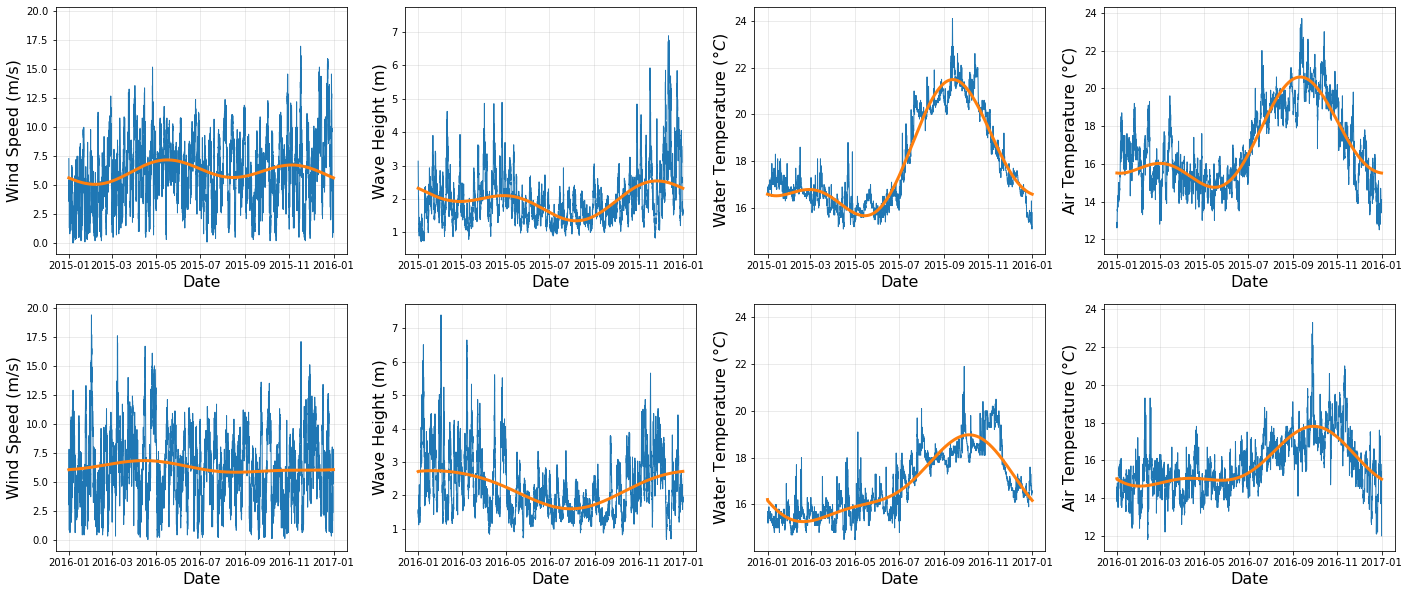

<function matplotlib.pyplot.close(fig=None)>

In [155]:
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(2, 4, hspace=0.2, wspace=0.2)
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = gs.subplots(sharey='col')
A1b, x1b, wind_2015_validb = plot_lin_fit(ax1, wind_2015, datetime_2015, y_label='Wind Speed (m/s)', P1=365, P2=182.5)
A2b, x2b, wave_height_2015_validb = plot_lin_fit(ax2, wave_height_2015, datetime_2015, y_label='Wave Height (m)', P1=365, P2=182.5)
A3b, x3b, water_temp_2015_validb = plot_lin_fit(ax3, water_temp_2015, datetime_2015, y_label='Water Temperature ($\degree C$)', P1=365, P2=182.5)
A4b, x4b, air_temp_2015_validb = plot_lin_fit(ax4, air_temp_2015, datetime_2015, y_label='Air Temperature ($\degree C$)', P1=365, P2=182.5)
A5b, x5b, wind_2016_validb = plot_lin_fit(ax5, wind_2016, datetime_2016, y_label='Wind Speed (m/s)', P1=366, P2=183)
A6b, x6b, wave_height_2016_validb = plot_lin_fit(ax6, wave_height_2016, datetime_2016, y_label='Wave Height (m)', P1=366, P2=183)
A7b, x7b, water_temp_2016_validb = plot_lin_fit(ax7, water_temp_2016, datetime_2016, y_label='Water Temperature ($\degree C$)', P1=366, P2=183)
A8b, x8b, air_temp_2016_validb = plot_lin_fit(ax8, air_temp_2016, datetime_2016, y_label='Air Temperature ($\degree C$)', P1=366, P2=183)
plt.show()
plt.close

In [197]:
print('The amplitude of the semi-annual cycle for 2015 windspeed is', round(np.sqrt(x1b[3]**2+x1b[4]**2),2), 'm/s')
print('The amplitude of the semi-annual cycle for 2015 wave height is', round(np.sqrt(x2b[3]**2+x2b[4]**2),2), 'm')
print('The amplitude of the semi-annual cycle for 2015 water temperature is', round(np.sqrt(x3b[3]**2+x3b[4]**2),2), '°C')
print('The amplitude of the semi-annual cycle for 2015 air temperature is', round(np.sqrt(x4b[3]**2+x4b[4]**2),2), '°C')
print('The amplitude of the semi-annual cycle for 2016 windspeed is', round(np.sqrt(x5b[3]**2+x5b[4]**2),2), 'm/s')
print('The amplitude of the semi-annual cycle for 2016 wave height is', round(np.sqrt(x6b[3]**2+x6b[4]**2),2), 'm')
print('The amplitude of the semi-annual cycle for 2016 water temperature is', round(np.sqrt(x7b[3]**2+x7b[4]**2),2), '°C')
print('The amplitude of the semi-annual cycle for 2016 air temperature is', round(np.sqrt(x8b[3]**2+x8b[4]**2),2), '°C')

The amplitude of the semi-annual cycle for 2015 windspeed is 0.79 m/s
The amplitude of the semi-annual cycle for 2015 wave height is 0.31 m
The amplitude of the semi-annual cycle for 2015 water temperature is 1.21 °C
The amplitude of the semi-annual cycle for 2015 air temperature is 1.33 °C
The amplitude of the semi-annual cycle for 2016 windspeed is 0.18 m/s
The amplitude of the semi-annual cycle for 2016 wave height is 0.06 m
The amplitude of the semi-annual cycle for 2016 water temperature is 0.51 °C
The amplitude of the semi-annual cycle for 2016 air temperature is 0.62 °C


In [198]:
print(x1a)
print(x1b)
print(x2a)
print(x2b)
print(x3a)
print(x3b)
print(x4a)
print(x4b)
print(x5a)
print(x5b)
print(x6a)
print(x6b)
print(x7a)
print(x7b)
print(x8a)
print(x8b)

[ 6.16154705 -0.02061527 -0.37050557]
[ 6.16135729 -0.02066582 -0.3700584  -0.77372707 -0.13665686]
[1.96836398 0.04054083 0.36761005]
[ 1.97008288  0.0421745   0.36837648 -0.31313891 -0.00950775]
[17.89178381 -2.38422018 -0.38658605]
[17.89138587 -2.38362767 -0.38823168  0.81055419 -0.90333104]
[16.95714545 -2.27761224 -0.505559  ]
[16.95707368 -2.27719049 -0.50623218  0.95007899 -0.93431778]
[ 6.2124756   0.43398743 -0.03374437]
[ 6.21269103  0.43382554 -0.03303041 -0.11176248 -0.14428904]
[2.22932773 0.25118404 0.51112852]
[ 2.22914835  0.25089725  0.51082465 -0.05723339 -0.02238314]
[16.83461204 -1.68019224 -0.18199125]
[16.83499977 -1.68085974 -0.18008861 -0.24578672 -0.44764366]
[15.79513305 -1.38600894 -0.15902839]
[15.79534674 -1.38697095 -0.1564104  -0.02758104 -0.61765966]


The amplitude of the semi-annual cycles are smaller than the annual cycles. Comparing the amplitudes of the first two sine/cosine waves between the annual and semi-annual cycle cases, it is clear that adding in additional waves for the semi-annual cycle does not change the amplitudes of the annual cycles.

# 5) Chi-squared and the misfit

In [206]:
print('The misfit between 2015 windspeed and an annual cycle is', round(np.sum((wind_2015_valida.values - A1a.dot(x1a))**2)/np.std(wind_2015_valida.values)**2))
print('The misfit between 2015 wave height and an annual cycle is', round(np.sum((wave_height_2015_valida.values - A2a.dot(x2a))**2)/np.std(wave_height_2015_valida.values)**2))
print('The misfit between 2015 water temperature and an annual cycle is', round(np.sum((water_temp_2015_valida.values - A3a.dot(x3a))**2)/np.std(water_temp_2015_valida.values)**2))
print('The misfit between 2015 air temperature and an annual cycle is', round(np.sum((air_temp_2015_valida.values - A4a.dot(x4a))**2)/np.std(air_temp_2015_valida.values)**2))
print('The misfit between 2015 windspeed and an annual cycle is', round(np.sum((wind_2016_valida.values - A5a.dot(x5a))**2)/np.std(wind_2016_valida.values)**2))
print('The misfit between 2015 wave height and an annual cycle is', round(np.sum((wave_height_2016_valida.values - A6a.dot(x6a))**2)/np.std(wave_height_2016_valida.values)**2))
print('The misfit between 2015 water temperature and an annual cycle is', round(np.sum((water_temp_2016_valida.values - A7a.dot(x7a))**2)/np.std(water_temp_2016_valida.values)**2))
print('The misfit between 2015 air temperature and an annual cycle is', round(np.sum((air_temp_2016_valida.values - A8a.dot(x8a))**2)/np.std(air_temp_2016_valida.values)**2), '\n')

print('The misfit between 2015 windspeed and a semi-annual cycle is', round(np.sum((wind_2015_validb.values - A1b.dot(x1b))**2)/np.std(wind_2015_validb.values)**2))
print('The misfit between 2015 wave height and a semi-annual cycle is', round(np.sum((wave_height_2015_validb.values - A2b.dot(x2b))**2)/np.std(wave_height_2015_validb.values)**2))
print('The misfit between 2015 water temperature and a semi-annual cycle is', round(np.sum((water_temp_2015_validb.values - A3b.dot(x3b))**2)/np.std(water_temp_2015_validb.values)**2))
print('The misfit between 2015 air temperature and a semi-annual cycle is', round(np.sum((air_temp_2015_validb.values - A4b.dot(x4b))**2)/np.std(air_temp_2015_validb.values)**2))
print('The misfit between 2015 windspeed and a semi-annual cycle is', round(np.sum((wind_2016_validb.values - A5b.dot(x5b))**2)/np.std(wind_2016_validb.values)**2))
print('The misfit between 2015 wave height and a semi-annual cycle is', round(np.sum((wave_height_2016_validb.values - A6b.dot(x6b))**2)/np.std(wave_height_2016_validb.values)**2))
print('The misfit between 2015 water temperature and a semi-annual cycle is', round(np.sum((water_temp_2016_validb.values - A7b.dot(x7b))**2)/np.std(water_temp_2016_validb.values)**2))
print('The misfit between 2015 air temperature and a semi-annual cycle is', round(np.sum((air_temp_2016_validb.values - A8b.dot(x8b))**2)/np.std(air_temp_2016_validb.values)**2))

The misfit between 2015 windspeed and an annual cycle is 8673
The misfit between 2015 wave height and an annual cycle is 7459
The misfit between 2015 water temperature and an annual cycle is 2309
The misfit between 2015 air temperature and an annual cycle is 3630
The misfit between 2015 windspeed and an annual cycle is 8613
The misfit between 2015 wave height and an annual cycle is 6951
The misfit between 2015 water temperature and an annual cycle is 2371
The misfit between 2015 air temperature and an annual cycle is 4764 

The misfit between 2015 windspeed and a semi-annual cycle is 8343
The misfit between 2015 wave height and a semi-annual cycle is 6795
The misfit between 2015 water temperature and a semi-annual cycle is 689
The misfit between 2015 air temperature and a semi-annual cycle is 1966
The misfit between 2015 windspeed and a semi-annual cycle is 8597
The misfit between 2015 wave height and a semi-annual cycle is 6931
The misfit between 2015 water temperature and a semi-annu

The misfit is smaller when you use the semi-annual cycle as well, meaning this model is a closer fit to the data. If you did this calculation using monthly data, then the misfits would be substantially less, as there would be far fewer data points.

For the annual cycle model, we have 52 - 3 = 49 degrees of freedom (one per week of the year minus one per model parameter). For the semi-annual cycle model we have 52 - 5 = 47 degrees of freedom. Using a chi-squared distribution, we can can see how well we are fitting the data. If the chi-squared test value is less than 0.05, then the data is not distinguishable from the model at the 95% confidence level.

In [222]:
print('The chi-squared test statistic for 2015 windspeed using an annual cycle model is', chi2.cdf(np.sum((wind_2015_valida.values - A1a.dot(x1a))**2)/np.std(wind_2015_valida.values)**2, 49))
print('The chi-squared test statistic for 2015 wave height using an annual cycle model is', chi2.cdf(np.sum((wave_height_2015_valida.values - A2a.dot(x2a))**2)/np.std(wave_height_2015_valida.values)**2, 49))
print('The chi-squared test statistic for 2015 water temperature using an annual cycle model is', chi2.cdf(np.sum((water_temp_2015_valida.values - A3a.dot(x3a))**2)/np.std(water_temp_2015_valida.values)**2, 49))
print('The chi-squared test statistic for 2015 air temperature using an annual cycle model is', chi2.cdf(np.sum((air_temp_2015_valida.values - A4a.dot(x4a))**2)/np.std(air_temp_2015_valida.values)**2, 49), '\n')

print('The chi-squared test statistic for 2015 windspeed using a semi-annual cycle model is', chi2.cdf(np.sum((wind_2015_valida.values - A1b.dot(x1b))**2)/np.std(wind_2015_validb.values)**2, 49))
print('The chi-squared test statistic for 2015 wave height using a semi-annual cycle model is', chi2.cdf(np.sum((wave_height_2015_valida.values - A2b.dot(x2b))**2)/np.std(wave_height_2015_validb.values)**2, 49))
print('The chi-squared test statistic for 2015 water temperature using a semi-annual cycle model is', chi2.cdf(np.sum((water_temp_2015_valida.values - A3b.dot(x3b))**2)/np.std(water_temp_2015_validb.values)**2, 49))
print('The chi-squared test statistic for 2015 air temperature using a semi-annual cycle model is', chi2.cdf(np.sum((air_temp_2015_valida.values - A4b.dot(x4b))**2)/np.std(air_temp_2015_validb.values)**2, 49))

The chi-squared test statistic for 2015 windspeed using an annual cycle model is 1.0
The chi-squared test statistic for 2015 wave height using an annual cycle model is 1.0
The chi-squared test statistic for 2015 water temperature using an annual cycle model is 1.0
The chi-squared test statistic for 2015 air temperature using an annual cycle model is 1.0 

The chi-squared test statistic for 2015 windspeed using a semi-annual cycle model is 1.0
The chi-squared test statistic for 2015 wave height using a semi-annual cycle model is 1.0
The chi-squared test statistic for 2015 water temperature using a semi-annual cycle model is 1.0
The chi-squared test statistic for 2015 air temperature using a semi-annual cycle model is 1.0


Therefore for all variables and both models, the data is underfitted. There is still a significant difference between the model and the data.

If we change the number of degrees of freedom by assuming there is one independent sample per day, we get n = 365 - 3 = 362 and n = 365 - 5 = 360.

In [223]:
print('The chi-squared test statistic for 2015 windspeed using an annual cycle model is', chi2.cdf(np.sum((wind_2015_valida.values - A1a.dot(x1a))**2)/np.std(wind_2015_valida.values)**2, 362))
print('The chi-squared test statistic for 2015 wave height using an annual cycle model is', chi2.cdf(np.sum((wave_height_2015_valida.values - A2a.dot(x2a))**2)/np.std(wave_height_2015_valida.values)**2, 362))
print('The chi-squared test statistic for 2015 water temperature using an annual cycle model is', chi2.cdf(np.sum((water_temp_2015_valida.values - A3a.dot(x3a))**2)/np.std(water_temp_2015_valida.values)**2, 362))
print('The chi-squared test statistic for 2015 air temperature using an annual cycle model is', chi2.cdf(np.sum((air_temp_2015_valida.values - A4a.dot(x4a))**2)/np.std(air_temp_2015_valida.values)**2, 362), '\n')

print('The chi-squared test statistic for 2015 windspeed using a semi-annual cycle model is', chi2.cdf(np.sum((wind_2015_valida.values - A1b.dot(x1b))**2)/np.std(wind_2015_validb.values)**2, 360))
print('The chi-squared test statistic for 2015 wave height using a semi-annual cycle model is', chi2.cdf(np.sum((wave_height_2015_valida.values - A2b.dot(x2b))**2)/np.std(wave_height_2015_validb.values)**2, 360))
print('The chi-squared test statistic for 2015 water temperature using a semi-annual cycle model is', chi2.cdf(np.sum((water_temp_2015_valida.values - A3b.dot(x3b))**2)/np.std(water_temp_2015_validb.values)**2, 360))
print('The chi-squared test statistic for 2015 air temperature using a semi-annual cycle model is', chi2.cdf(np.sum((air_temp_2015_valida.values - A4b.dot(x4b))**2)/np.std(air_temp_2015_validb.values)**2, 360))

The chi-squared test statistic for 2015 windspeed using an annual cycle model is 1.0
The chi-squared test statistic for 2015 wave height using an annual cycle model is 1.0
The chi-squared test statistic for 2015 water temperature using an annual cycle model is 1.0
The chi-squared test statistic for 2015 air temperature using an annual cycle model is 1.0 

The chi-squared test statistic for 2015 windspeed using a semi-annual cycle model is 1.0
The chi-squared test statistic for 2015 wave height using a semi-annual cycle model is 1.0
The chi-squared test statistic for 2015 water temperature using a semi-annual cycle model is 1.0
The chi-squared test statistic for 2015 air temperature using a semi-annual cycle model is 1.0


This does not make a difference. We still have too much data, giving us misfits that are too large. If we had only daily values of windspeed, wave height, water temperature and air temperature, then the misfit value would be much small and the chi-squared value would be smaller, possibly less than 0.05 in some cases.

For example, if we take the 2015 water temperature semi-annual model, and assume that we only have one data point per day, then we can divide the misfit by 24 (to get an approximate value). If we recalculate the chi-square test statistic using this we get a small value, which suggests that we cannot differentiate the model from the data. 

In [226]:
print('If we only had daily data, the chi-squared test statistic for 2015 water temperature using a semi-annual cycle model would be', chi2.cdf(np.sum((water_temp_2015_valida.values - A3b.dot(x3b))**2)/np.std(water_temp_2015_validb.values)**2/24, 360), 'assuming that there is one independent sample per day')


If we only had daily data, the chi-squared test statistic for 2015 water temperature using a semi-annual cycle model would be 6.051919341190391e-128 assuming that there is one independent sample per day
